# `multidms` fitting pipeline

Here, we demonstrate the pipeline for fitting a `multidms` model on some data using the tools available in the package. Currently, we show how to pre-process data from various dms experiments targeting Delta and Omicron spike protein homologs.

In [455]:
# built-in libraries
import os
import sys
from itertools import combinations
from collections import defaultdict
import time

# external dependencies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as onp
from tqdm.notebook import tqdm
import jax.numpy as jnp

import multidms
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Read in the dms data and list all available experimental conditions**

In [468]:
func_score_data = pd.DataFrame()
sites = {}
wt_seqs = {}

for homolog in ["Delta", "Omicron_BA.1", "Omicron_BA.2"]:
    
    # functional scores
    func_sel = pd.read_csv(f"../results/{homolog}/functional_selections.csv")
    func_sel = func_sel.assign(
        filename = f"../results/{homolog}/" + 
        func_sel.library + "_" + 
        func_sel.preselection_sample + 
        "_vs_" + func_sel.postselection_sample + 
        "_func_scores.csv"
    )
    func_sel = func_sel.assign(
        func_sel_scores_df = func_sel.filename.apply(lambda f: pd.read_csv(f))
    )
    func_sel = func_sel.assign(
        len_func_sel_scores_df = func_sel.func_sel_scores_df.apply(lambda x: len(x))
    )
    fun_sel = func_sel.assign(homolog = homolog)
    func_score_data = pd.concat([func_score_data, fun_sel]).reset_index(drop=True)

# Add a column that gives a unique ID to each homolog/DMS experiment
func_score_data['condition'] = func_score_data.apply(
    lambda row: f"{row['homolog']}-{row['library']}".replace('-Lib',''),
#     lambda row: f"{row['homolog']}-{row['library']}-{row['replicate']}".replace('-Lib',''),
    axis=1
)
func_score_data

,preselection_sample,library,virus_batch,replicate,postselection_sample,preselection_library_sample,postselection_library_sample,selection_name,filename,func_sel_scores_df,len_func_sel_scores_df,homolog,condition
0,2021-10-28_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1,Lib-1_2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-1_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,45131,Delta,Delta-1
1,2021-10-28_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2,Lib-1_2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-1_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,45131,Delta,Delta-1
2,2021-10-28_thaw-1_VSVG_control_1,Lib-3,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1,Lib-3_2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3
3,2021-10-28_thaw-1_VSVG_control_2,Lib-3,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2,Lib-3_2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3
4,2021-10-28_thaw-1_VSVG_control_1,Lib-4,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1,Lib-4_2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4
5,2021-10-28_thaw-1_VSVG_control_2,Lib-4,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2,Lib-4_2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4
6,2021-10-28_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1,Lib-2_2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,41586,Delta,Delta-2
7,2021-10-28_thaw-1_VSVG_control_2,Lib-2,thaw-1,2,2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2,Lib-2_2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,41586,Delta,Delta-2
8,2022-03-25_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1,Lib-1_2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.1/Lib-1_2022-03-25_thaw-...,library pre_sampl...,94347,Omicron_BA.1,Omicron_BA.1-1
9,2022-03-25_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2,Lib-1_2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2_vs_2022...,../results/Omicron_BA.1/Lib-1_2022-03-25_thaw-...,library pre_sampl...,94347,Omicron_BA.1,Omicron_BA.1-1


**Define all the knobs which define the pipeline's pre-preprocessing behavior**

In [469]:
prep_params = {
    # pre-processing params
    "scale_counts" : False,
    "min_pre_counts" : 100,
    "pseudocount" : 0.1,
    "sample" : False, #5000,
    "min_pre_counts" : 100,
    "clip_target" : (-3.5, 2.5),
    "trim" : False,
    "reference_condition" : "Omicron_BA.2-1",
    "conditions" : [ #["Delta-3"] #( # ["Delta-3-1"] #(
#         "Delta-2", "Delta-3"#, #,
#         "Omicron_BA.1-2", "Omicron_BA.1-3" #,
        "Omicron_BA.2-1", "Omicron_BA.2-2"
    ]
}

In [470]:
# uncomment to reset or if first time running notebook
# datasets = pd.DataFrame(columns=list(prep_params.keys()) + ["data"])

## Pre-Proccessing

**Query the conditions to be included in a fit**

In [471]:
func_score_data_sub = func_score_data.query(
    f"condition.isin({list(prep_params['conditions'])})"
)
func_score_data_sub

,preselection_sample,library,virus_batch,replicate,postselection_sample,preselection_library_sample,postselection_library_sample,selection_name,filename,func_sel_scores_df,len_func_sel_scores_df,homolog,condition
12,2022-10-22_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2022-10-22_thaw-1_no-antibody_control_1,Lib-1_2022-10-22_thaw-1_VSVG_control_1,Lib-1_2022-10-22_thaw-1_no-antibody_control_1,Lib-1_2022-10-22_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.2/Lib-1_2022-10-22_thaw-...,library pre_sampl...,90992,Omicron_BA.2,Omicron_BA.2-1
13,2022-10-22_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2022-10-22_thaw-1_no-antibody_control_1,Lib-2_2022-10-22_thaw-1_VSVG_control_1,Lib-2_2022-10-22_thaw-1_no-antibody_control_1,Lib-2_2022-10-22_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.2/Lib-2_2022-10-22_thaw-...,library pre_sampl...,85210,Omicron_BA.2,Omicron_BA.2-2
14,2022-10-22_thaw-2_VSVG_control_1,Lib-1,thaw-2,2,2022-10-22_thaw-2_no-antibody_control_1,Lib-1_2022-10-22_thaw-2_VSVG_control_1,Lib-1_2022-10-22_thaw-2_no-antibody_control_1,Lib-1_2022-10-22_thaw-2_VSVG_control_1_vs_2022...,../results/Omicron_BA.2/Lib-1_2022-10-22_thaw-...,library pre_sampl...,90992,Omicron_BA.2,Omicron_BA.2-1
15,2022-10-22_thaw-2_VSVG_control_1,Lib-2,thaw-2,2,2022-10-22_thaw-2_no-antibody_control_1,Lib-2_2022-10-22_thaw-2_VSVG_control_1,Lib-2_2022-10-22_thaw-2_no-antibody_control_1,Lib-2_2022-10-22_thaw-2_VSVG_control_1_vs_2022...,../results/Omicron_BA.2/Lib-2_2022-10-22_thaw-...,library pre_sampl...,85210,Omicron_BA.2,Omicron_BA.2-2


In [472]:
func_score_df = pd.DataFrame()
for idx, row in tqdm(func_score_data.iterrows(), total=len(func_score_data_sub)):
    df = row.func_sel_scores_df.assign(homolog=row.homolog)
    df = df.assign(library = row.library)
    df = df.assign(replicate = row.replicate)
    exp_func_score_df = df.assign(condition=row.condition)
    func_score_df = pd.concat([func_score_df, exp_func_score_df])
func_score_df.rename({"aa_substitutions_reference":"aa_substitutions"}, axis=1, inplace=True)
func_score_df.head()

  0%|          | 0/4 [00:00<?, ?it/s]

,library,pre_sample,post_sample,barcode,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_codon_substitutions,aa_substitutions_sequential,n_aa_substitutions,aa_substitutions,pre_count_threshold,homolog,replicate,condition
0,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,CAAATTCATTATGTTC,-0.9244,0.0006,11079,5259,1187006,1069422,0.5,4,R212G N437- A844H L1242-,4,R214G N439- A846H L1244-,23,Delta,1,Delta-1
1,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,TAGGATAGTAACTTGA,-0.4382,0.0005,9613,6392,1187006,1069422,0.5,5,N485T T676Y A686G A843R,4,N487T T678Y A688G A845R,23,Delta,1,Delta-1
2,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,TCTACAGCGATAAAGA,-0.0208,0.0005,8879,7885,1187006,1069422,0.5,3,R78G D226Y G445D,3,R78G D228Y G447D,23,Delta,1,Delta-1
3,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,CACTATTTATTTTGAC,-0.2993,0.0007,7396,5415,1187006,1069422,0.5,2,E778D D1161G,2,E780D D1163G,23,Delta,1,Delta-1
4,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,GCATAGCTAATAATCA,-0.7267,0.0009,6813,3709,1187006,1069422,0.5,3,A258V T825I Y1204H,3,A260V T827I Y1206H,23,Delta,1,Delta-1


**Optionally subset the variants**

In [461]:
if prep_params["sample"]:
    func_score_df = func_score_df.sample(prep_params["sample"])

**remove all variants with string sites and stop codon wildtypes**

In [473]:
func_score_df.aa_substitutions.fillna("", inplace=True)
gapped_sub_vars = []
stop_wt_vars = []
non_numeric_sites = []
for idx, row in tqdm(func_score_df.iterrows(), total=len(func_score_df)):
    if "-" in row["aa_substitutions"]:
        gapped_sub_vars.append(idx)
    for sub in row["aa_substitutions"].split():
        if sub[0] == "*":
            stop_wt_vars.append(idx)
        if not sub[-2].isnumeric():
            non_numeric_sites.append(idx)

to_drop = set.union(set(gapped_sub_vars), set(stop_wt_vars), set(non_numeric_sites))
func_score_df.drop(to_drop, inplace=True)

  0%|          | 0/1135096 [00:00<?, ?it/s]

**Drop all variants with pre-counts below a threshold.**

In [474]:
# Drop barcoded variants with pre-counts below a threshold
n_pre_threshold = len(func_score_df)
func_score_df = func_score_df[func_score_df['pre_count'] >= prep_params["min_pre_counts"]]
print(f"Of {n_pre_threshold} variants, {n_pre_threshold - len(func_score_df)} had fewer than {prep_params['min_pre_counts']} counts before selection, and were filtered out")

Of 701777 variants, 90677 had fewer than 100 counts before selection, and were filtered out


**Optionally, scale the counts**

In [475]:
if prep_params['scale_counts']:
    func_score_df = multidms.utils.scale_func_score(func_score_df)

**Optionally, clip the target functional scores**

In [476]:
if prep_params['clip_target'] and prep_params['trim']:
    l,h = prep_params['clip_target']
    func_score_trim = func_score_df.query(
        f"(func_score >= {l}) & (func_score <= {h})"
    )
    diff = len(func_score_df) - len(func_score_trim)
    print(f"Of {len(func_score_df)} variants, {diff} were thrown during trimming")
    func_score_df = func_score_trim

In [477]:
if prep_params['clip_target'] and not prep_params['trim']:
    func_score_df['func_score'] = func_score_df['func_score'].clip(*prep_params['clip_target'])

In [479]:
# func_score_df.to_csv("Delta_BA1_BA2_func_score_df.csv")

## `MultiDmsData`

**After the functional score dataframe for all variants has been prepped, you can now initialize a `mulidms.MultiDmsData` Object. This will (1) convert substitution string to be with respect to a reference (if necessary) (2) set static attributes and (3) prep model training data which can be shared by multiple `multidms.MulitDmsModel` objects.**

In [ ]:
# uncomment to see docs
# help(multidms.MultiDmsData)

In [ ]:
# tqdm.pandas()
data = multidms.MultiDmsData(
    func_score_df,
    alphabet= multidms.AAS_WITHSTOP,
    condition_colors = sns.color_palette("Paired"),
    reference=prep_params['reference_condition']
)

**To analyze multiple datasets, we store the data object along with it's defining features in a dataframe.**

In [ ]:
data_row = pd.Series(prep_params).to_frame().T
data_row['data'] = data
datasets = pd.concat([datasets, data_row], ignore_index=True)
datasets

In [ ]:
import multidms.model
x = jnp.array(onp.linspace(-10, 10, 100))
custom_params = {"ge_scale":jnp.array([5]) , "ge_bias":jnp.array([50])}
y = multidms.model.softplus_global_epistasis(custom_params, x)
plt.plot(x, y)
plt.show()

In [ ]:
datasets

## `MultiDmsModel`

**To fit a mopdel, we first choose a dataset(s) we would like to fit**

In [385]:
# models_df

In [ ]:
# un-comment to re-initialize results
# models = defaultdict(list)

**Next, we iterate through datasets and model definitions of interest and (1) initialize a model object with the respective dataset (2) fit that data to a model with some given hyperparameters and (3) save the models in a dataframe for comparison and plotting.**

In [ ]:
for dataset in datasets.index:
    for ge_func in ["sigmoid", "softplus", "identity"]:
        for output_act in ["softplus"]:
            
            imodel = multidms.MultiDmsModel(
                    datasets.loc[dataset, 'data'],
                    latent_model="phi",
                    epistatic_model=ge_func,
                    output_activation=output_act
            )
            
            start = time.time()
            imodel.fit(lasso_shift=1e-5, maxiter=5000, tol=1e-6)
            end = time.time()
            print(f"{ge_func},{output_act} done. fitting time = {round(end - start), 2} seconds")
            
            models["ge_func"].append(ge_func)
            models["output_act"].append(output_act)
            models["model"].append(imodel)
            models["dataset"].append(dataset)
            
models_df = pd.DataFrame(models)
models_df.tail(20)

In [ ]:
a_model_object = models_df.loc[0, "model"]
a_model_object

**models with the same dataset share the reference. This saves precious memory.**

In [ ]:
model_w_same_dataset = models_df.loc[1, "model"]
model_w_same_dataset.data is a_model_object.data

**The Model object shares many similar properties from the data object, like mutations and variants dataframes, but the getters give you useful model-specific features like parameters and predictions.**

In [ ]:
a_model_object.mutations_df

In [ ]:
a_model_object.variants_df

### Visualization

**The one mutable attribute of MultiDmsData objects is the condition_colors. We will set a custom color patte to be shared across datasets such that our multiple fit plots are consistant.**

In [ ]:
colors = list(sns.color_palette("colorblind", 6))
conditions = sorted(datasets.loc[0, "data"].conditions)
cc = {con:tuple(col) for con, col in zip(conditions, colors)}
for row, values in datasets.iterrows():
    values.data.condition_colors = cc

In [ ]:
print(sorted(datasets.loc[0, "data"].conditions))

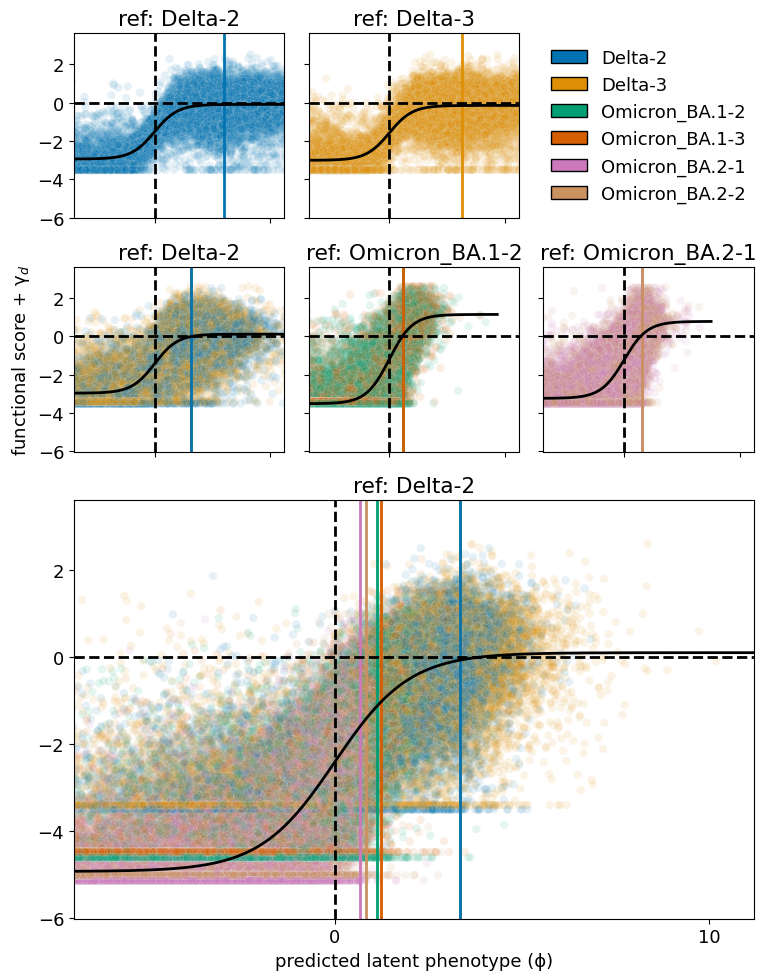

In [386]:
plt.rcParams.update({'font.size': 13})
fig = plt.figure(constrained_layout=True, figsize=(8,10))
axd = fig.subplot_mosaic(
    """
    abc
    def
    ggg
    ggg
    """,
    empty_sentinel="X",
    sharex=True,
    sharey=True,
)

model_ax_dict = {
    "a" : 9,
    "b" : 12,
    "d" : 15,
    "e" : 18,
    "f" : 21,
    "g" : 0
}

for axi, model in model_ax_dict.items():
    moi = models_df.loc[model, "model"]
    moi.plot_epistasis(show=False, legend=False, alpha=0.10, ax=axd[axi])
    axd[axi].set_title(f"ref: {moi.data.reference}")
axd["a"].set_ylabel("")
axd["g"].set_ylabel("")
axd["c"].axis('off')
legend_elements = [
    patches.Patch(
         facecolor=col, 
         edgecolor="black", 
         label=con
    )
    for con, col in cc.items()
]
axd["c"].legend(
        handles=legend_elements, 
        loc="center",
        frameon=False
)
plt.tight_layout()
fig.savefig("model-mixing-delta.png")
plt.show()

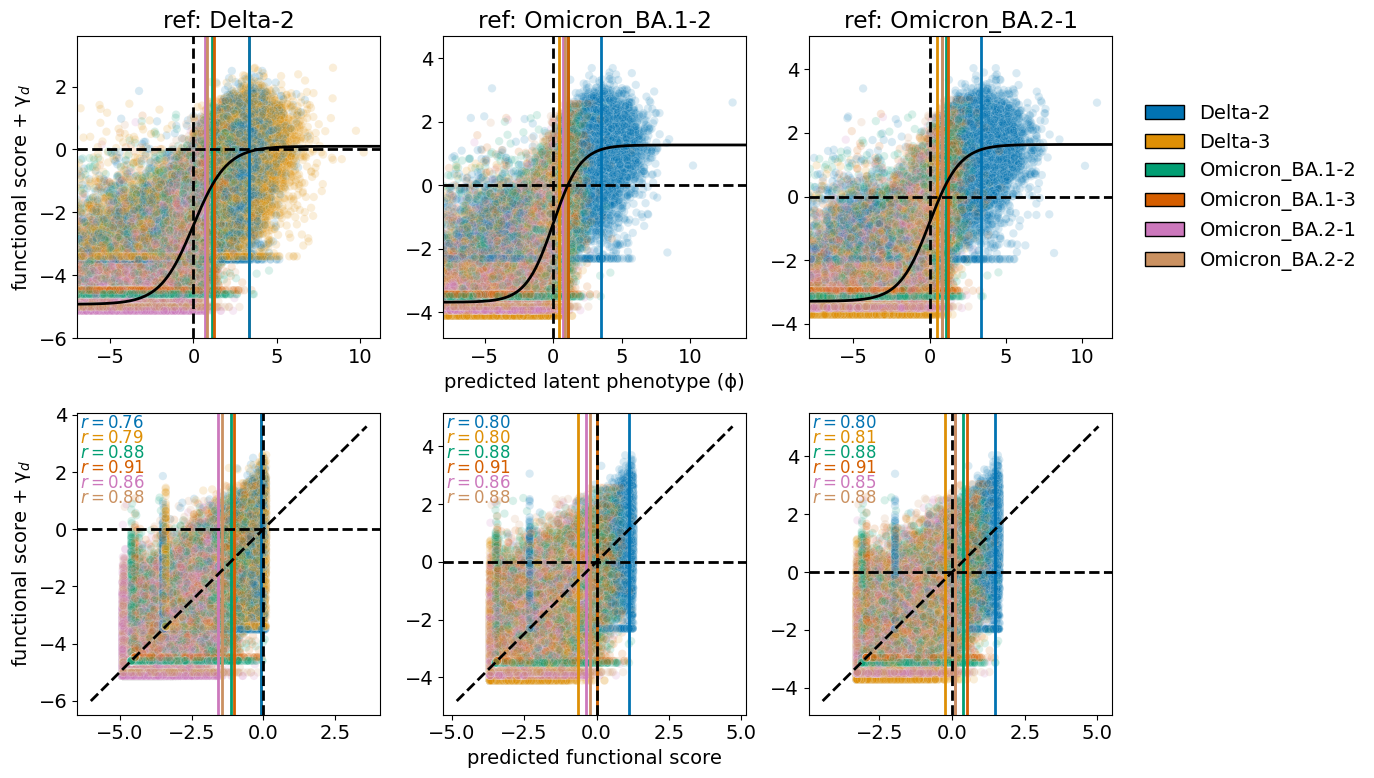

In [387]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(constrained_layout=True, figsize=(14,8))
axd = fig.subplot_mosaic(
    """
    abcg
    defX
    """,
    empty_sentinel="X",
#     sharex=True,
#     sharey=True,
    width_ratios=[2, 2, 2, 1],
)

# which fits go where
model_ax_dict = {
    "a" : 0,
    "b" : 3,
    "c" : 6,
    "d" : 0,
    "e" : 3,
    "f" : 6
}

for axi, model in model_ax_dict.items():
    moi = models_df.loc[model, "model"]
    if axi in ["a", "b", "c"]:
        moi.plot_epistasis(show=False, legend=False, alpha=0.15, ax=axd[axi])
        axd[axi].set_title(f"ref: {moi.data.reference}")
    else:
        moi.plot_pred_accuracy(show=False, legend=False, alpha=0.15, ax=axd[axi])


axd["b"].set_ylabel("")
axd["e"].set_ylabel("")
axd["c"].set_ylabel("")
axd["f"].set_ylabel("")

axd["a"].set_xlabel("")
axd["d"].set_xlabel("")
axd["c"].set_xlabel("")
axd["f"].set_xlabel("")

axd["g"].axis('off')
legend_elements = [
    patches.Patch(
         facecolor=col, 
         edgecolor="black", 
         label=con
    )
    for con, col in cc.items()
]
axd["g"].legend(
        handles=legend_elements, 
        loc="center",
        frameon=False
)
plt.tight_layout()
fig.savefig("ref-comparison-scatter-epi-acc.png")
plt.show()

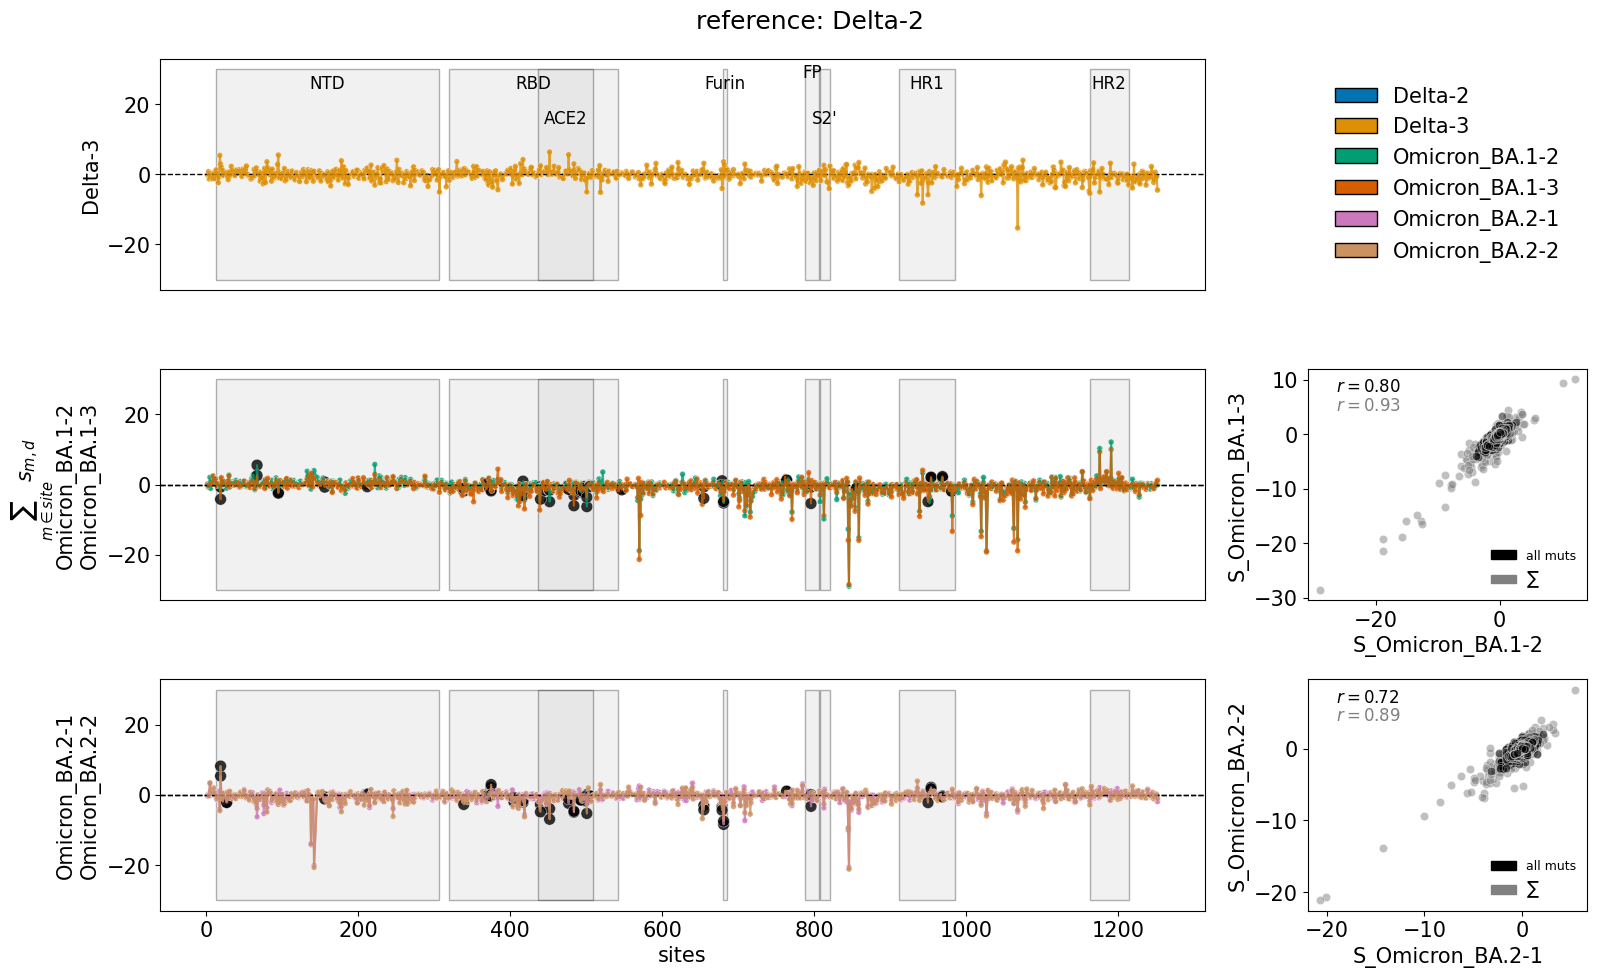

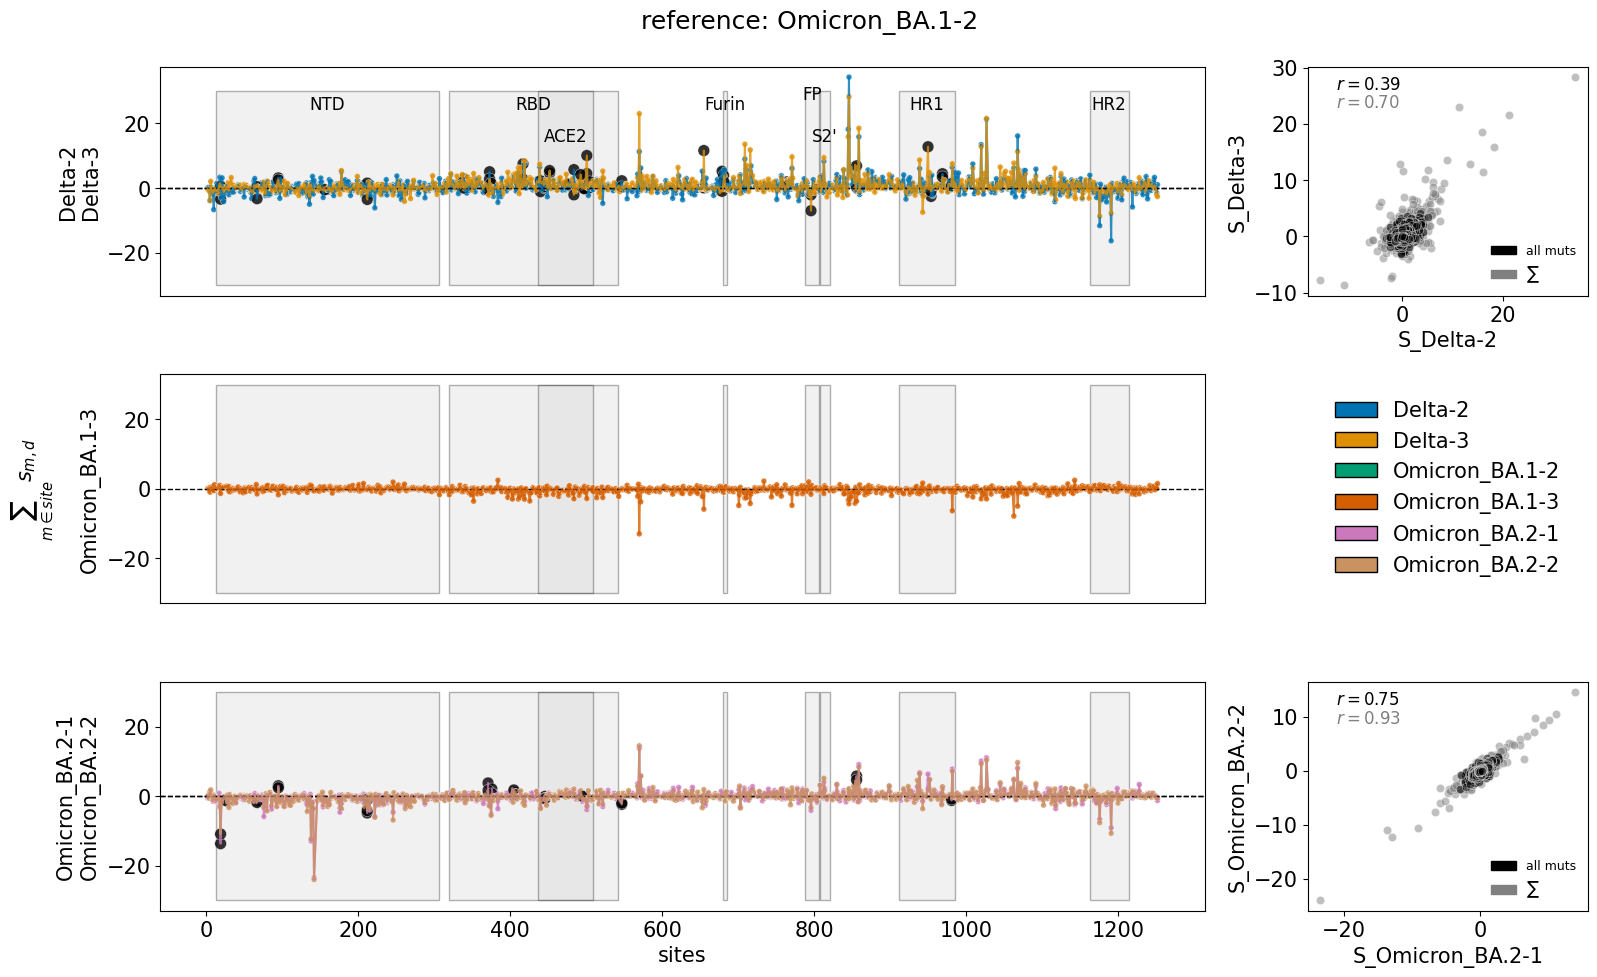

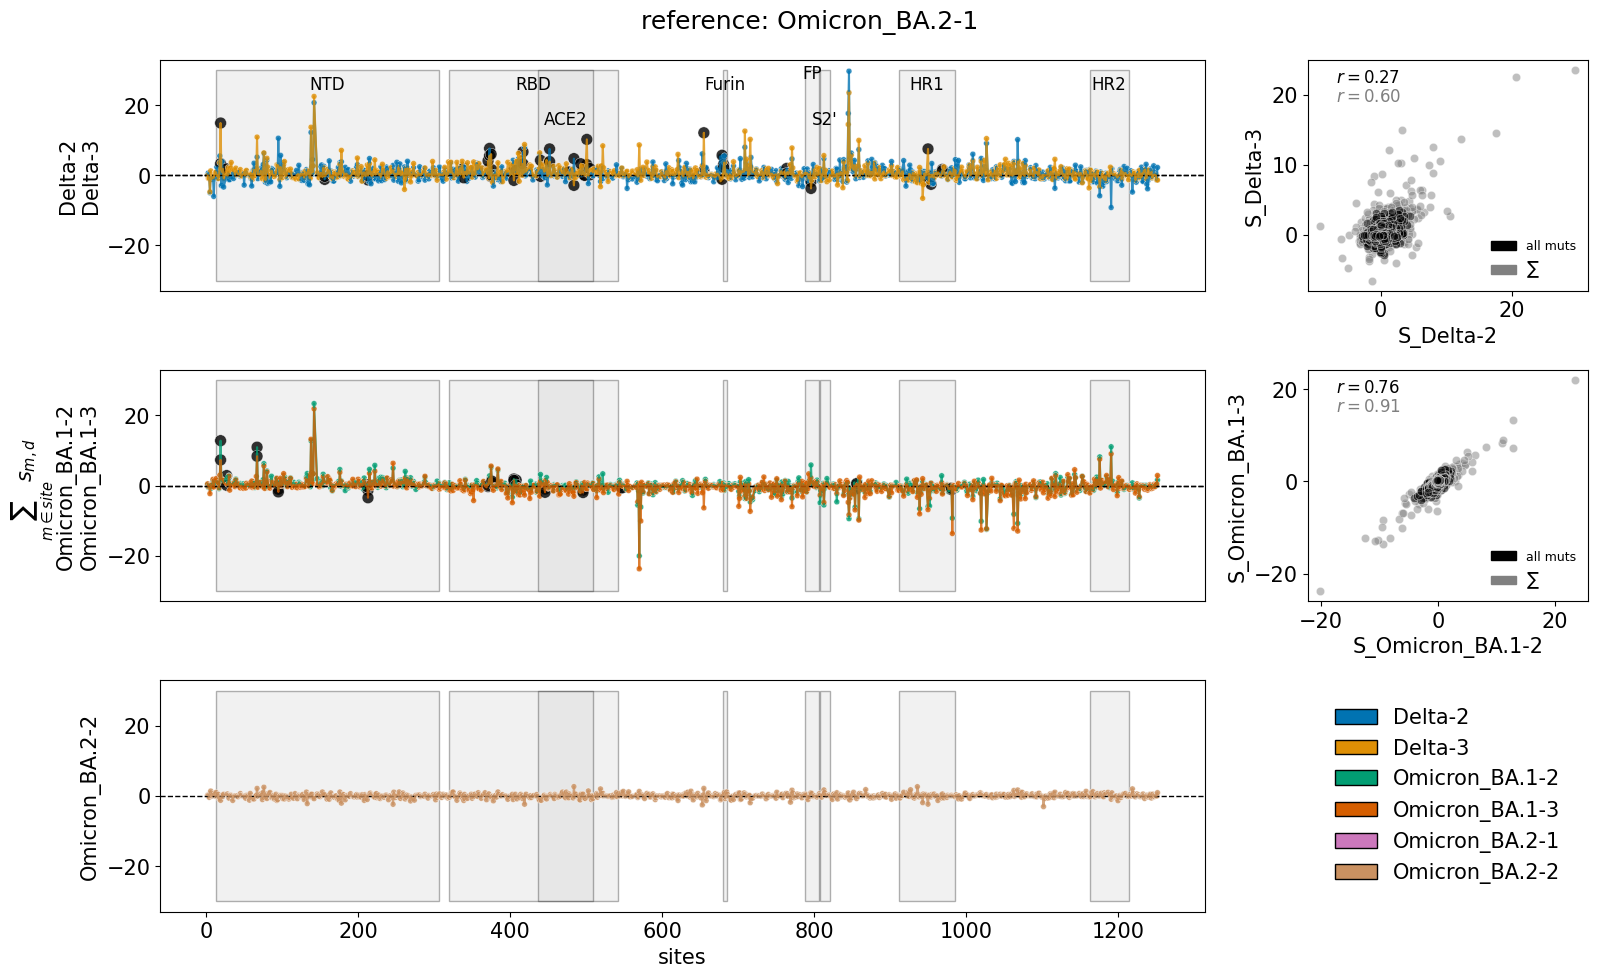

In [388]:
def sum_abs(x): 
    return sum([abs(t) for t in x if t == t])
def mean_abs(x): 
    return onp.mean([abs(t) for t in x if t == t])
def max_abs(x): 
    return onp.max([abs(t) for t in x if t == t])

plt.rcParams.update({'font.size': 15})

#         aceX
for model in [0, 3, 6]:
    fig = plt.figure(constrained_layout=True, figsize=(16,10))
    axd = fig.subplot_mosaic(
        """
        bbbg
        dddh
        fffi
        """,
        empty_sentinel="X",
        gridspec_kw={
#         "bottom": 0.25,
#         "top": 0.95,
#         "left": 0.1,
#         "right": 0.5,
#         "wspace": 0.5,
#         "hspace": 0.2,
#         "wspace": 0.2  
        }
    )

    protein_regions = {
        "NTD" :  [13, 305],                                                 
        "RBD" : [319, 541],
        "ACE2" : [437, 508],
        "Furin" : [680, 685],
        "FP" : [788, 806],
        "S2'"  : [808, 820],
        "HR1" : [912, 984],
        "HR2" : [1163, 1213]
    }
    
    

    moi = models_df.loc[model, "model"]
    fig.suptitle(f"reference: {moi.data.reference}")
#     fig.suptitle(f"Reference: {moi.data.reference}\n")
#     moi.plot_epistasis(show=False, legend=False, alpha=0.05, ax=axd["c"])
#     moi.plot_pred_accuracy(show=False, legend=False, alpha=0.05, ax=axd["e"], annotate_corr=False)

    facet_groups = {
        ("b", "g") : ("Delta-2", "Delta-3"),
        ("d", "h") : ("Omicron_BA.1-2", "Omicron_BA.1-3"),
        ("f", "i") : ("Omicron_BA.2-1", "Omicron_BA.2-2")
    }

    for axi, facet_group in facet_groups.items():

        for pr, data in protein_regions.items():

            start = data[0]
            end = data[1] + 1
            width = end - start
            middle = start + (width//2)

            rect_v = patches.Rectangle(
                    (start, -30),
                    width=width,
                    height=60,
                    clip_on=False,
                    linewidth=1,
                    edgecolor='black',
                    facecolor='lightgrey',
                    alpha=0.3
            )
            axd[axi[0]].add_patch(rect_v)

        condition_ylabel = []
        for condition in facet_group:
            
            if condition == moi.data.reference: continue
            
            condition_ylabel.append(condition)
            moi.plot_shifts_by_site(
                condition,
                show=False, 
                agg_func=onp.sum,
                times_seen_threshold=3,
                ax=axd[axi[0]],
                alpha=0.8
            )
            
        ylabel =  '\n' + '\n'.join(condition_ylabel)
#         if axi[0] == "d":
#             ylabel = "$\sum_{m \in site}s_{m,d}$\n" + ylabel
        axd[axi[0]].set_ylabel(ylabel)
        
        if moi.data.reference not in facet_group:
            
            from scipy.stats import pearsonr
            
            mut_df = moi.mutation_site_summary_df(agg_func=onp.sum, times_seen_threshold=3)
#             mut_df = moi.mutations_df
            
            times_seen_cols = [c for c in mut_df.columns if "times" in c]
            for c in times_seen_cols:
                mut_df = mut_df[mut_df[c]>=3]
                
            x = mut_df[f"S_{facet_group[0]}"].values
            y = mut_df[f"S_{facet_group[1]}"].values
            r = pearsonr(x, y)[0]
            sns.scatterplot(mut_df,
                x=f"S_{facet_group[0]}",
                y=f"S_{facet_group[1]}", 
                ax=axd[axi[1]],
                alpha=0.5,
                color="grey"
                
            )
            axd[axi[1]].annotate(
                f"$r = {r:.2f}$", (0.1, 0.82),
                xycoords="axes fraction", fontsize=12, color="grey"
            )
            
            legend_elements = [
                patches.Patch(
                     facecolor="black", 
                     edgecolor="black", 
                     label="all muts"
                ),
                patches.Patch(
                    facecolor="grey", 
                    edgecolor="grey", 
                    label="$\sum$" #_{m \in site}s_{m,d}$"
                )
                
            ]
            axd[axi[1]].legend(
                    handles=legend_elements, 
                    loc="lower right",
                    frameon=False,
                    fontsize=9
            )
            
            mut_df = moi.mutations_df
            
            times_seen_cols = [c for c in mut_df.columns if "times" in c]
            for c in times_seen_cols:
                mut_df = mut_df[mut_df[c]>=3]
                
            x = mut_df[f"S_{facet_group[0]}"].values
            y = mut_df[f"S_{facet_group[1]}"].values
            r = pearsonr(x, y)[0]
            sns.scatterplot(mut_df,
                x=f"S_{facet_group[0]}",
                y=f"S_{facet_group[1]}", 
                ax=axd[axi[1]],
                alpha=0.5,
                color="black"
            )
            axd[axi[1]].annotate(
                f"$r = {r:.2f}$", (0.1, 0.9),
                xycoords="axes fraction", fontsize=12, color="black"
            )
        
                 
        else:
            
            axd[axi[1]].axis('off')
            legend_elements = [
                patches.Patch(
                     facecolor=col, 
                     edgecolor="black", 
                     label=con
                )
                for con, col in cc.items()
            ]
            axd[axi[1]].legend(
                    handles=legend_elements, 
                    loc="center",
                    frameon=False
            )
            
    for pr, data in protein_regions.items():

        start = data[0]
        end = data[1] + 1
        width = end - start
        middle = start + (width//2)

        anno = f"{pr}" #": \n{start}-{end}"
        ycoord = 26
        if pr in ["ACE2", "S2'"]:
            ycoord = 16
        if pr in ["FP"]:
            ycoord = 29

        axd["b"].text(middle, ycoord, anno, va="center", ha="center", size=12, rotation=0)

    axd["b"].get_xaxis().set_visible(False)
    axd["d"].get_xaxis().set_visible(False)
    

    fig.text(0.00, 0.5, "$\sum_{m \in site}s_{m,d}$", va='center', rotation='vertical')
    plt.tight_layout()
    plt.show()

    fig.savefig(f"shifts_reference_{moi.data.reference}.png")

In [423]:
import pickle
moi = models_df.loc[0, "model"]
pickle.dump(moi, open("delta-6c-sigmoid.pkl", "wb"))

PicklingError: Can't pickle <function φ at 0x7f7a9b5a9090>: it's not the same object as multidms.model.φ

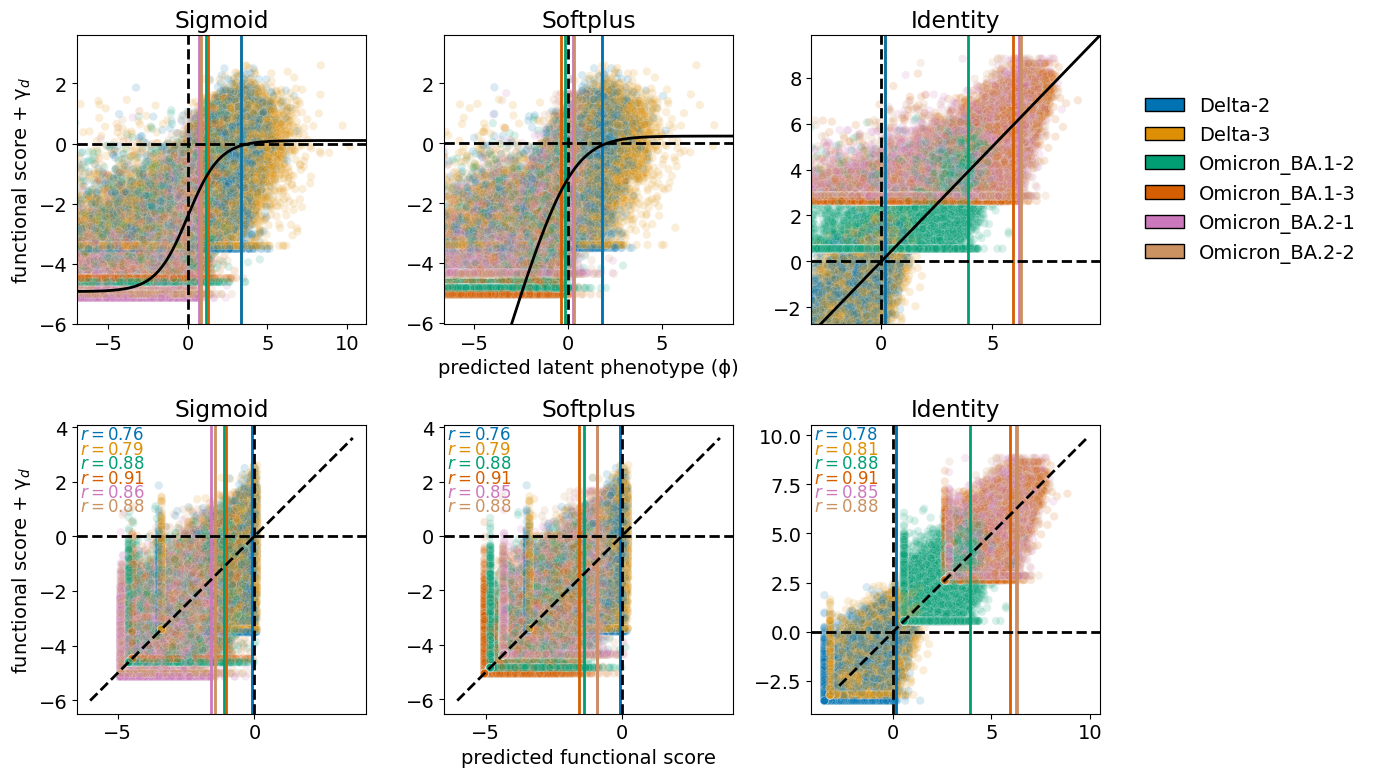

In [389]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(constrained_layout=True, figsize=(14,8))
axd = fig.subplot_mosaic(
    """
    abcg
    defX
    """,
    empty_sentinel="X",
#     sharex=True,
#     sharey=True,
    width_ratios=[2, 2, 2, 1],
)

# which fits go where
model_ax_dict = {
    "a" : 0,
    "b" : 1,
    "c" : 2,
    "d" : 0,
    "e" : 1,
    "f" : 2
}

for axi, model in model_ax_dict.items():
    moi = models_df.loc[model, "model"]
    if axi in ["a", "b", "c"]:
        moi.plot_epistasis(show=False, legend=False, alpha=0.15, ax=axd[axi])
    else:
        moi.plot_pred_accuracy(show=False, legend=False, alpha=0.15, ax=axd[axi])
    
    epi = "Sigmoid"
    if axi in ["b", "e"]:
        epi = "Softplus"
    if axi in ["c", "f"]:
        epi = "Identity"
        
    axd[axi].set_title(epi)

axd["b"].set_ylabel("")
axd["e"].set_ylabel("")
axd["c"].set_ylabel("")
axd["f"].set_ylabel("")

axd["a"].set_xlabel("")
axd["d"].set_xlabel("")
axd["c"].set_xlabel("")
axd["f"].set_xlabel("")

axd["g"].axis('off')
legend_elements = [
    patches.Patch(
         facecolor=col, 
         edgecolor="black", 
         label=con
    )
    for con, col in cc.items()
]
axd["g"].legend(
        handles=legend_elements, 
        loc="center",
        frameon=False
)
plt.tight_layout()
fig.savefig("epi-model-compare.png")
plt.show()

In [390]:
plt.rcParams.update({'font.size': 13})

from functools import reduce
mutations_dfs = []
for model, ge_func in zip([0,1,2], ["sigmoid", "softplus", "identity"]):
    mut_df = models_df.loc[model, "model"].mutations_df.set_index("mutation")
    
    new_column_name_map = {c:f"{c}_{ge_func}" for c in mut_df.columns}
    mut_df = mut_df.rename(new_column_name_map, axis=1)
    times_seen_cols = [c for c in mut_df.columns if "times" in c]
    for c in times_seen_cols:
        mut_df = mut_df[mut_df[c] >= 3]
    mutations_dfs.append(mut_df)
    

df_merged = reduce(
    lambda  left,right: pd.merge(
        left,
        right,
        left_index=True, 
        right_index=True,
        how='outer'
    ), 
    mutations_dfs
)
df_merged.head()

df_merged = df_merged.assign(is_stop = [True if "*" in mut else False for mut in df_merged.index])

In [401]:
df_merged.head()

,wts_sigmoid,sites_sigmoid,muts_sigmoid,times_seen_Delta-2_sigmoid,times_seen_Delta-3_sigmoid,times_seen_Omicron_BA.1-2_sigmoid,times_seen_Omicron_BA.1-3_sigmoid,times_seen_Omicron_BA.2-1_sigmoid,times_seen_Omicron_BA.2-2_sigmoid,β_sigmoid,...,F_Delta-2_identity,S_Omicron_BA.1-2_identity,F_Omicron_BA.1-2_identity,S_Omicron_BA.1-3_identity,F_Omicron_BA.1-3_identity,S_Omicron_BA.2-1_identity,F_Omicron_BA.2-1_identity,S_Omicron_BA.2-2_identity,F_Omicron_BA.2-2_identity,is_stop
mutation,,,,,,,,,,,,,,,,,,,,,
F2L,F,2,L,6.0,6.0,9.0,5.0,18.0,13.0,0.275083,...,0.447965,0.049545,0.596820,0.231695,2.632415,-0.097301,2.83864,-0.008817,2.857695,False
V3A,V,3,A,9.0,3.0,19.0,21.0,7.0,11.0,-0.073450,...,0.057410,0.212364,0.556408,0.062111,2.632415,-0.028637,2.83864,0.032945,2.857695,False
V3F,V,3,F,7.0,11.0,59.0,56.0,76.0,59.0,-0.374142,...,-0.391433,0.065434,0.550564,0.090747,2.632415,0.125906,2.83864,0.366628,2.857695,False
V3G,V,3,G,16.0,8.0,42.0,27.0,35.0,26.0,0.150277,...,0.225466,-0.017358,0.553753,-0.038212,2.632415,-0.066601,2.83864,-0.238173,2.857695,False
V3I,V,3,I,7.0,12.0,59.0,49.0,62.0,60.0,-0.229850,...,0.033534,0.024551,0.551272,-0.237518,2.632415,0.127085,2.83864,-0.004629,2.857695,False


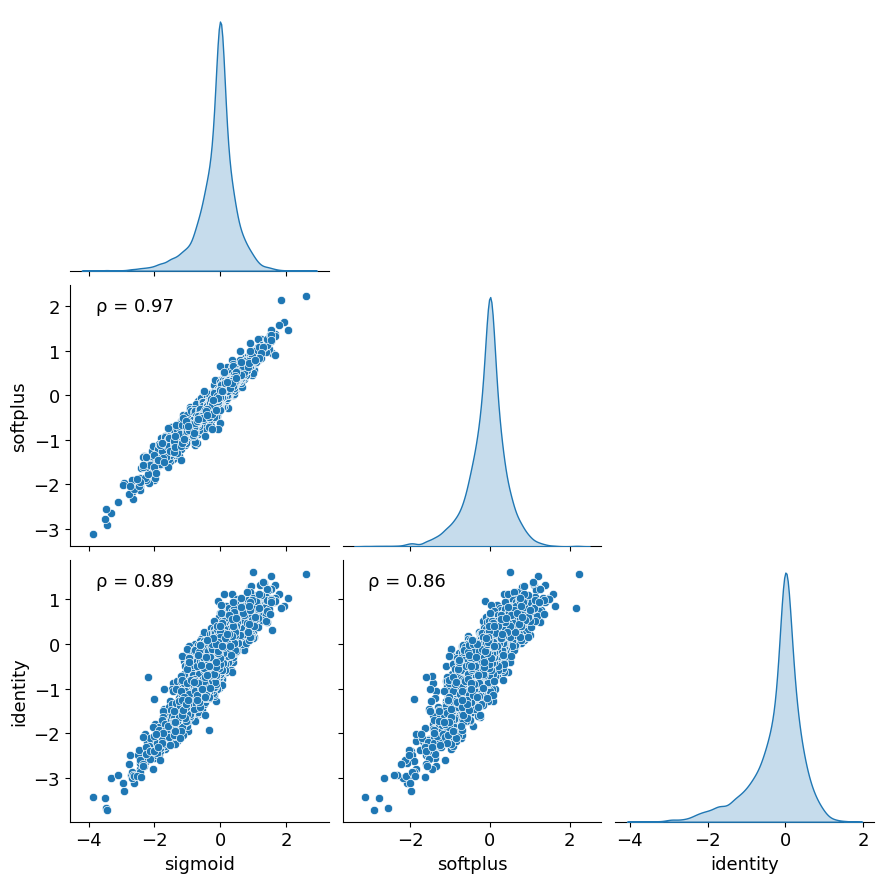

In [392]:
# fig, ax = plt.subplots(figsize=[9, 9])
shifts_map = {
    c:c.split("_")[-1] 
    for c in df_merged.columns 
    if "S_Omicron_BA.1-2" in c
}
g = sns.pairplot(
    data = df_merged.rename(shifts_map, axis=1), 
    vars=shifts_map.values(), 
#     hue="is_stop", 
    diag_kind="kde", 
    corner=True,
    height=3
#     ax=ax
)
def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    
g.map_lower(corrfunc)

g.savefig("shift-correlation.png")
plt.show()